In [1]:
# !pip install -q kaggle

In [2]:
# !mkdir ~/.kaggle

In [3]:
# !touch ~/.kaggle/kaggle.json

In [4]:
# !kaggle competitions download -c histopathologic-cancer-detection

In [5]:
#!pip install torchvision

In [6]:
#!pip install --upgrade torch torchvision

In [7]:
#!pip install scikit-learn

In [8]:
#!pip install tqdm

In [9]:
#!pip3 install torchvision 

In [70]:
import os
import re
import pandas as pd
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models
from torch import optim
from torch.utils.data import DataLoader
from sklearn import preprocessing

import numpy as np
import pandas as pd
import os
import scipy.ndimage as ndi
import shutil

In [71]:
import os
import re
import pandas as pd
import numpy as np
import torch
from torch import nn
from tqdm.notebook import tqdm
# import torchio as tio
# from torchio import AFFINE, DATA
from torchvision import datasets, transforms, models
from torch import optim
from torch.utils.data import DataLoader
from sklearn import preprocessing

import numpy as np
import pandas as pd
import os
import scipy.ndimage as ndi
import shutil

import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)


In [72]:
import time
n_qubits = 4                # Number of qubits
step = 0.000004               # Learning rate
batch_size = 8              # Number of samples for each training step
num_epochs = 25              # Number of training epochs
q_depth = 1                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [73]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
dev = qml.device('braket.aws.qubit', device_arn=device_arn, wires=n_qubits)
dev

<BraketAwsQubitDevice device (wires=4, shots=None) at 0x7f0e9efafd90>

In [74]:
#!pip install sagemaker

In [75]:
#!pip3 install s3fs 

In [76]:
#%pip install --upgrade boto3

In [77]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

In [78]:
bucket='kaggle-cancer-dataset'
data_key = 'train_labels.csv'
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=data_key)
#s3://kaggle-cancer-dataset/train_labels.csv

train_data = pd.read_csv(obj['Body'])
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [79]:
train_data_numpy = train_data.values
print(train_data_numpy[0:5])

[['f38a6374c348f90b587e046aac6079959adf3835' 0]
 ['c18f2d887b7ae4f6742ee445113fa1aef383ed77' 1]
 ['755db6279dae599ebb4d39a9123cce439965282d' 0]
 ['bc3f0c64fb968ff4a8bd33af6971ecae77c75e08' 0]
 ['068aba587a4950175d04c680d38943fd488d6a9d' 0]]


In [80]:
from sklearn.model_selection import train_test_split
data_train, data_val= train_test_split(train_data_numpy, test_size = 0.25, random_state=42,stratify=train_data_numpy[:,1])

In [81]:
print(len(train_data_numpy))
print(len(data_train))
print(len(data_val))

220025
165018
55007


(96, 96, 3)


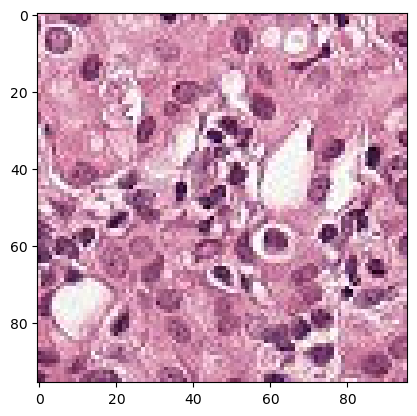

In [82]:
from PIL import Image
import matplotlib.pyplot as plt
bucket1 = 'kaggle-cancer-dataset'
key1 = "train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif"
obj = s3.get_object(Bucket=bucket1, Key=key1)

image_array = Image.open(obj['Body'])
numpy_array = np.asarray(image_array)
print(numpy_array.shape)
plt.imshow(image_array)
plt.show()

In [83]:
df_train = pd.DataFrame(data_train,columns=["id","label"])
df_train.head()

,id,label
0,8df301c4ad7d43129fc71a0d20bc4d9dcda9784d,0
1,1bf89407709c983c5adce3817c3e282b3f5aeeb8,1
2,7f7c3615a5cc5d2344547b42a8e11da72438df29,0
3,bfeb523231e132e6c2bcddd3092c92441d945a8b,0
4,2e6a00a31191eb31ec82fc9ebfe316857258ba0d,1


In [84]:
df_val = pd.DataFrame(data_val,columns=["id","label"])
df_val.head()

,id,label
0,e1891b5f3d318cbe4113967df5bd84c2daa50821,0
1,2d0ead94b22d68fdcea6675d05e77eb1bf332cad,0
2,c2fb3601e594459fb7622729121628b90962fd0b,0
3,3e54b88196229d3c39a52eb77657f25119e53b42,1
4,c67dd4fb6906aa79e3c8b7a9dd7732f2fad8ef22,0


In [85]:
df_train.to_csv('train_data_new.csv',index=False,header=False)
df_val.to_csv('val_data_new.csv',index=False,header=False)

In [86]:
# Send these file to s3 using terminal
#https://www.middlewareinventory.com/blog/ec2-s3-copy/ -> commands

In [87]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Cancerclass(Dataset):
    def __init__(self,csv_data,root_dir,key,transform=None):
        self.bucket_name = root_dir
        self.key = key
        self.transform = transform
        self.data = csv_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        filename = str(self.data[idx][0])
        bucket1 = self.bucket_name
        key1 = self.key +"/" + filename + '.tif'
        obj = s3.get_object(Bucket=bucket1, Key=key1)

        image_array = Image.open(obj['Body'])
        image_array1 = image_array

        del image_array
       
        label = int(self.data[idx][1])

        if self.transform:
            tensor_image = self.transform(image_array1)

        return tensor_image,label

In [88]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [90]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def U_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.U3(element[0],element[1],element[2],wires=idx)
        
def entangling_layer1(nqubits):
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[2,3])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[0,3])

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [91]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # # # Sequence of trainable variational layers
    entangling_layer1(4)
    U_layer([[q_weights[0],q_weights[1],q_weights[2]],[q_weights[3],q_weights[4],q_weights[5]],[q_weights[6],q_weights[7],q_weights[8]],[q_weights[9],q_weights[10],q_weights[11]]])
    
    entangling_layer1(4)
    U_layer([[q_weights[12],q_weights[13],q_weights[14]],[q_weights[15],q_weights[16],q_weights[17]],[q_weights[18],q_weights[19],q_weights[20]],[q_weights[21],q_weights[22],q_weights[23]]])
    
    entangling_layer1(4)
    U_layer([[q_weights[24],q_weights[25],q_weights[26]],[q_weights[27],q_weights[28],q_weights[29]],[q_weights[30],q_weights[31],q_weights[32]],[q_weights[33],q_weights[34],q_weights[35]]])
    
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[2,3])
    qml.CNOT(wires=[1,2])
    qml.CNOT(wires=[3,0])
    
    qml.RZ(q_weights[36],wires=0)
    qml.RZ(q_weights[37],wires=1)
    qml.RZ(q_weights[38],wires=2)
    qml.RZ(q_weights[39],wires=3)
    
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [92]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.rand(40)) # 2 for QAOA //rand
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [93]:
model_hybrid = models.resnet18(pretrained=True)
model_hybrid.fc = DressedQuantumNet()
model_hybrid = model_hybrid.to(device)

/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [94]:
model_hybrid.apply(init_weights)

/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [95]:
batch_size = 16
train_set = Cancerclass(data_train,'kaggle-cancer-dataset',"train",transforms.Compose(
    [transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)

test_set = Cancerclass(data_val, 'kaggle-cancer-dataset',"train", transforms.Compose([transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_set,batch_size=batch_size, shuffle=False)

In [96]:
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model_hybrid.parameters(),lr=1E-5)
exp_lr_scheduler = lr_scheduler.StepLR(
    opt, step_size=10, gamma=gamma_lr_scheduler
)

In [97]:
def evaluation(dataloader,model):
    with torch.no_grad():
        total,correct = 0,0
        for data in dataloader:
            inputs,labels = data
            inputs,labels = inputs.to(device),labels.to(device)
            outputs = model(inputs)
            _,pred = torch.max(outputs.data,1) 
            total += labels.size(0)
            correct += (pred==labels).sum().item()

        return 100*correct/total

In [98]:
loss_arr = []
epoch_loss_arr = []
epoch_acc = []
import copy
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    print("Training started:")
    for epoch in range(num_epochs):
        model.train()
        for i, data in enumerate(train_loader,0):
            print(i)
            inputs, labels = data
            batch_size_ = len(inputs)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_arr.append(loss.item())
        

        epoch_loss_arr.append(loss.item())
        epoch_acc.append(evaluation(train_loader,model))
        print(model.fc.q_params)
        print(
                    "Epoch: {}/{} Train Loss: {:.4f} Train Acc: {:.4f} Val Acc: {:.4f} ".format(
                        epoch,
                        num_epochs,
                        epoch_loss_arr[-1],
                        epoch_acc[-1],
                        evaluation(val_loader,model)
                    )
                )
        PATH = '/content/' + 'model_' + str(epoch) + '.pt'
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss.item(),
                }, PATH)
          #best_model_wts = copy.deepcopy(model.state_dict())
          # Update learning rate
        scheduler.step()
      #model.load_state_dict(best_model_wts)
       
    # Print final results
    return model

In [ ]:
model_hybrid = train_model(
    model_hybrid, loss_fn, opt, exp_lr_scheduler, num_epochs=25
)

plt.plot(epoch_loss_arr)
plt.show()

Training started:
0


In [ ]:
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# loss_arr = []
# loss_epoch_arr = []
# max_epochs = 25

# for epoch in tqdm(range(max_epochs)):
#     for i, data in enumerate(train_loader,0):
#         inputs, labels = data
#         inputs,labels = inputs.to(device),labels.to(device)
#         opt.zero_grad()

#         outputs = model(inputs)
#         _,pred_labels = torch.max(outputs.data,1)
#         loss = loss_fn(outputs,labels)
#         loss.backward()
#         opt.step()
#         del inputs,labels

#         loss_arr.append(loss.item())

# #     PATH = '/content/' + 'model_' + str(epoch) + '.pt'
  
  
#     loss_epoch_arr.append(loss.item())
#     print('Epoch = %d/%d, Train Acc: %0.2f, Test Acc: %0.2f '%(epoch,max_epochs,evaluation(train_loader),
#         evaluation(test_loader)))
# #     torch.save({
# #             'epoch': epoch,
# #             'model_state_dict': model.state_dict(),
# #             'optimizer_state_dict': opt.state_dict(),
# #             'loss': loss.item(),
# #             }, PATH)


# plt.plot(loss_epoch_arr)
# plt.show()

In [ ]:
# import sagemaker
# from sagemaker.debugger import Rule, rule_configs
# from sagemaker.session import TrainingInput

# region = sagemaker.Session().boto_region_name
# print("AWS Region: {}".format(region))

# role = sagemaker.get_execution_role()
# print("RoleArn: {}".format(role))

# s3_output_location='s3://{}/{}/{}'.format('kaggle-cancer-dataset', 'models', 'xgboost_model')

# container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
# print(container)

# xgb_model=sagemaker.estimator.Estimator(
#     image_uri=container,
#     role=role,
#     instance_count=1,
#     instance_type='ml.m4.xlarge',
#     volume_size=5,
#     output_path=s3_output_location,
#     sagemaker_session=sagemaker.Session(),
#     rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
# )

In [ ]:
# xgb_model.set_hyperparameters(
#     max_depth = 5,
#     eta = 0.2,
#     gamma = 4,
#     min_child_weight = 6,
#     subsample = 0.7,
#     objective = "binary:logistic",
#     num_round = 1000
# )

In [ ]:
# from sagemaker.session import TrainingInput

# train_input = TrainingInput(
#     "s3://{}/{}".format('kaggle-cancer-dataset', "train_data_new.csv"), content_type="csv"
# )
# validation_input = TrainingInput(
#     "s3://{}/{}".format('kaggle-cancer-dataset',"val_data_new.csv"), content_type="csv"
# )

In [ ]:
# xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)